# Analyse ACCESS-S2 forecasts for wet 2022 events

In [1]:
from dask_jobqueue import PBSCluster
from dask.distributed import Client

In [1]:
# One node on Gadi has 48 cores - try and use up a full node before going to multiple nodes (jobs)

walltime = '01:00:00'
cores = 10
memory = str(4 * cores)
memory = memory + 'GB'

cluster = PBSCluster(walltime=str(walltime), cores=cores, memory=str(memory), processes=cores,
                     job_extra_directives=['-q normal',
                                           '-P w42',
                                           '-l ncpus='+str(cores),
                                           '-l mem='+str(memory),
                                           '-l storage=gdata/w42+gdata/rt52+gdata/ux62'],
                     local_directory='$TMPDIR',
                     job_directives_skip=["select"])

NameError: name 'PBSCluster' is not defined

In [3]:
cluster.scale(jobs=1)
client = Client(cluster)

In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: /proxy/36009/status,
Dashboard: /proxy/36009/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.121.5:34539,Workers: 0
Dashboard: /proxy/36009/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
# client.close()
# cluster.close()

In [2]:
import os
import xarray as xr
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

import cartopy.crs as ccrs
import cartopy
cartopy.config['pre_existing_data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'
cartopy.config['data_dir'] = '/g/data/w42/dr6273/work/data/cartopy-data'

In [3]:
def get_plot_params():
    """
    Get the plotting parameters used for figures
    """
    FONT_SIZE = 7
    COASTLINES_LW = 0.5
    LINEWIDTH = 1.3
    PATHEFFECT_LW_ADD = LINEWIDTH * 1.8

    return {'lines.linewidth': LINEWIDTH,
            'hatch.linewidth': 0.5,
            'font.size': FONT_SIZE,
            'legend.fontsize' : FONT_SIZE - 1,
            'legend.columnspacing': 0.7,
            'legend.labelspacing' : 0.03,
            'legend.handlelength' : 1.,
            'axes.linewidth': 0.5}

plt_params = get_plot_params()

# Load hindcast climatology

In [6]:
hcast_clim = xr.open_zarr(
    '/g/data/w42/dr6273/work/data/access-s2/pr_hindcast_clim_1981-2018.zarr',
    consolidated=True
)

In [69]:
hcast_clim.groupby('dayofyear.month')

AttributeError: 'IndexVariable' object has no attribute 'month'

# Load forecast data

In [8]:
fc_path = '/g/data/w42/lz3062/s2_fcst/'

Get initialisation dates

In [9]:
init_dates = sorted(os.listdir(fc_path)) # Initialisation dates. Note directory structure is different to hindcast data.

Obtain dataset of all forecasts, with dimensions for ensemble member (member; 1-33), lat, lon, forecast target date (target_date), forecast initialisation date (init_date).

### EDIT:
Actually, it is easier to compute the forecast anomalies if we have a lead time dimension (lead_time), so let's do that instead of a target date.

In [17]:
ds_list = []
for init in init_dates: # loop through each init date
    members = sorted(os.listdir(fc_path + init))
    files = []
    for member, file in enumerate(members):
        fcast = xr.open_mfdataset(fc_path + init + '/' + file)
        fcast = fcast.expand_dims({'member': [member + 1]}) # give this dataset the ensemble dimension
        files.append(fcast)
        
    fcast_ens = xr.concat(files, dim='member') # concatenate over all members
    # fcast_ens = fcast_ens.rename({'time': 'target_date'}) # rename time to target_date
    fcast_ens = fcast_ens.expand_dims({'init_date': [fcast_ens['time'].values[0]]}) # assign new init date dimension
    fcast_ens = fcast_ens.rename({'time': 'lead_time'}) # rename time to target_date
    fcast_ens = fcast_ens.assign_coords({'lead_time': range(len(fcast_ens['lead_time']))})
    
    ds_list.append(fcast_ens)
    
fcast_ds = xr.concat(ds_list, dim='init_date') # concat over all init dates

In [19]:
fcast_ds

<xarray.Dataset>
Dimensions:    (init_date: 18, member: 33, lat: 324, lon: 432, lead_time: 42)
Coordinates:
  * init_date  (init_date) datetime64[ns] 2022-02-22T12:00:00 ... 2022-10-01T...
  * member     (member) int64 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
  * lat        (lat) float32 -89.72 -89.17 -88.61 -88.06 ... 88.61 89.17 89.72
  * lon        (lon) float32 0.4167 1.25 2.083 2.917 ... 357.1 357.9 358.8 359.6
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 ... 34 35 36 37 38 39 40 41
Data variables:
    pr         (init_date, member, lead_time, lat, lon) float32 dask.array<chunksize=(1, 1, 42, 324, 432), meta=np.ndarray>
Attributes: (12/25)
    model_id:                ACCESS-S2
    distribution_statement:  The data are subject to the distribution terms o...
    creator_name:            Bureau of Meteorology
    copyright:               (C) Copyright Commonwealth of Australia (2017), ...
    acknowledgement:         Australian Bureau of Meteorology, Commonwealth o...
    title:                   ACCESS-S2
    ...                      ...
    input_file_format:       UM ancillary
    input_uri:               file:///g/sc/home_prod/coupled_prod/cylc-run/acc...
    input_word_length:       8
    history:                 Wed Feb 23 07:57:16 2022: ncks -O -v pr /g/sc/ho...
    input_byte_ordering:     big_endian
    NCO:                     "4.5.3"

# Set forecast target periods

In [44]:
# format is {init_date: [first_target_date, last_target_date]}
feb_target_lead0 = {'2022-02-24': ['2022-02-24', '2022-03-02']}
mar_target_lead0 = {'2022-03-03': ['2022-03-03', '2022-03-09']}

jul_target_lead1 = {'2022-06-23': ['2022-06-30', '2022-07-06']}
jul_target_lead0 = {'2022-06-30': ['2022-06-30', '2022-07-06']}

oct_target_lead1 = {'2022-09-01': ['2022-10-01', '2022-10-31']}
oct_target_lead0 = {'2022-10-01': ['2022-10-01', '2022-10-31']}

Convert these to lead times.

In [45]:
for period in [
    feb_target_lead0,
    mar_target_lead0,
    jul_target_lead1,
    jul_target_lead0,
    oct_target_lead1,
    oct_target_lead0
]:
    # Get init and target dates
    init = pd.to_datetime(list(period.keys())[0])
    t1 = pd.to_datetime(list(period.values())[0][0])
    t2 = pd.to_datetime(list(period.values())[0][1])
    
    # Calculate lead times
    period[list(period.keys())[0]].append((t1 - init).days)
    period[list(period.keys())[0]].append((t2 - init).days)

# An example: Take a look at first period

In [53]:
init = list(feb_target_lead0.keys())[0]
lead_slice = slice(feb_target_lead0[init][2], feb_target_lead0[init][3])

In [55]:
i_init = np.where(pd.to_datetime(fcast_ds['init_date'].values) == init+'-12')[0][0]

In [56]:
fcast = fcast_ds.isel(init_date=range(i_init - 2, i_init + 1))
fcast = fcast.sel(lead_time=lead_slice)
fcast = fcast['pr']

In [65]:
list(fcast.groupby('init_date.dayofyear').groups.keys())

[53, 54, 55]

### Compute climatology for this period

In [66]:
hcast_clim.sel(dayofyear = list(fcast.groupby('init_date.dayofyear').groups.keys()))

<xarray.Dataset>
Dimensions:    (dayofyear: 3, lat: 63, lead_time: 62, lon: 60)
Coordinates:
  * dayofyear  (dayofyear) int64 53 54 55
  * lat        (lat) float32 -44.72 -44.17 -43.61 ... -11.39 -10.83 -10.28
  * lead_time  (lead_time) int64 0 1 2 3 4 5 6 7 8 ... 54 55 56 57 58 59 60 61
  * lon        (lon) float32 110.4 111.2 112.1 112.9 ... 157.1 157.9 158.8 159.6
Data variables:
    pr         (dayofyear, lead_time, lat, lon) float32 dask.array<chunksize=(3, 62, 63, 60), meta=np.ndarray>

In [68]:
hcast_clim.dayofyear[:100]

<xarray.DataArray 'dayofyear' (dayofyear: 100)>
array([  1,   6,  11,  14,  15,  16,  21,  24,  25,  26,  27,  28,  29,  30,
        31,  32,  37,  42,  45,  46,  47,  52,  53,  54,  55,  56,  57,  58,
        59,  60,  61,  65,  66,  70,  71,  73,  74,  75,  76,  80,  81,  83,
        84,  85,  86,  87,  88,  89,  90,  91,  92,  96,  97, 101, 102, 104,
       105, 106, 107, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121,
       122, 126, 127, 131, 132, 134, 135, 136, 137, 141, 142, 144, 145, 146,
       147, 148, 149, 150, 151, 152, 153, 157, 158, 162, 163, 165, 166, 167,
       168, 172])
Coordinates:
  * dayofyear  (dayofyear) int64 1 6 11 14 15 16 21 ... 163 165 166 167 168 172

In [145]:
aus_region = [110, 155, -10, -45]

In [148]:
fcast_plot = fcast.sel(
    lon=slice(aus_region[0], aus_region[1]),
    lat=slice(aus_region[3], aus_region[2])
)

Mean rainfall forecast for 24/02 through 02/03, initialised on 24/02.
Ensemble average of 99 members from 3 initialisation dates.

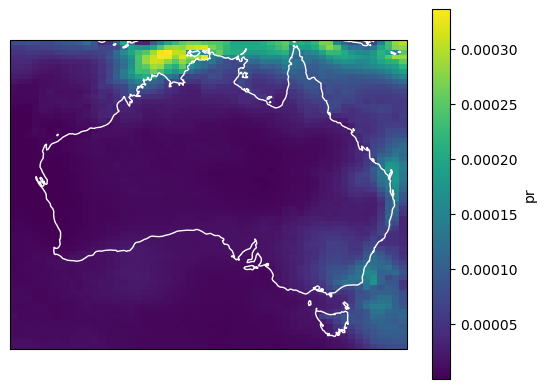

In [152]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': ccrs.PlateCarree()})
fcast_plot.mean(['init_date', 'target_date', 'member']).plot(ax=ax)
ax.coastlines(color='white')